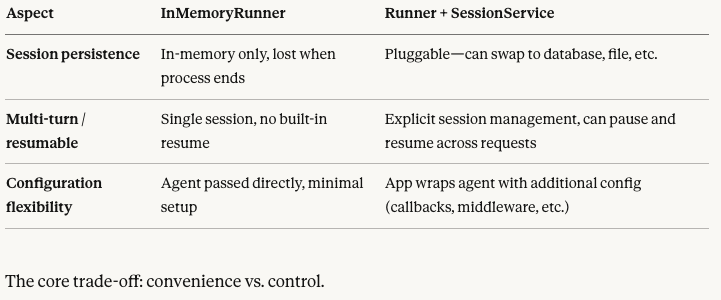

# Agent Tool Patterns and Best Practices

In this notebook, you'll learn how to:

- ✅ **Connect to external MCP servers**
- ✅ **Implement long-running operations** that can pause agent execution for external input
- ✅ **Build resumable workflows** that maintain state across conversation breaks


<span style="color:red"> **TO DISCUSS WITH BW** </span>

For the app, two ways to run

**option 1**

```
session_service = InMemorySessionService()

shipping_runner = Runner(
    app=shipping_app,  # Pass the app instead of the agent
    session_service=session_service,
)
resp = await shipping_runner.run_debug("Ship 3 containers to Singapore")
```

**option2**

``` 
session_id = f"order_{uuid.uuid4().hex[:8]}"

await session_service.create_session(
    app_name="shipping_coordinator", user_id="test_user", session_id=session_id
)

query_content = types.Content(role="user", parts=[types.Part(text=query)])
events = []


async for event in shipping_runner.run_async(
    user_id="test_user", session_id=session_id, new_message=query_content
):
    events.append(event)
```

---
# 1. Setup

In [1]:
# load api key
# -------------
import os
from dotenv import load_dotenv 

load_dotenv()

try:
    GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )


# import dependencies
# -------------------
import uuid
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters

from google.adk.apps.app import App, ResumabilityConfig
from google.adk.tools.function_tool import FunctionTool

print("✅ ADK components imported successfully.")


# retry config
# -------------------
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

✅ Setup and authentication complete.
✅ ADK components imported successfully.


---
# 2. Model Context Protocol

**Previous**: custom tool.

**Now**: connecting to external systems (GitHub, databases, Slack) which requires writing and maintaining API clients.

### <span style="color:blue">What is Model Context Protocol (MCP)</span>
MCP is an open standard that lets agents use community-built integrations. Instead of writing your own integrations and API clients, just connect to an existing MCP server.

> **Problem**: Connecting agents to external services (databases, APIs, Slack) requires writing custom API clients for each one.

> **Solution**: MCP standardizes how agents talk to external services. Community members build MCP servers (wrappers) that follow this standard.

> **Benefit**: Just connect to an existing MCP server - no custom code needed.

###  <span style="color:blue">Why MCP When APIs Already Exist?</span>

> **Problem**: Every service has its own API, but each speaks a different "language":

| Service | Auth | Format | SDK |
|---------|------|--------|-----|
| Slack | OAuth | JSON | `slack-sdk` |
| GitHub | Token | JSON | `PyGithub` |
| PostgreSQL | User/Pass | SQL rows | `psycopg2` |


> **Solution**: MCP wraps each service into ONE standardized interface. Your agent speaks one language; the MCP server translates.

> **Benefit**: Add 10 services without learning 10 SDKs. Just plug in MCP servers.


### <span style="color:blue">MCP vs Middleware</span>
> **Key insight**: MCP = middleware + universal standard. Like HTTP standardized web communication, MCP standardizes agent-tool communication.

| | Middleware (general) | MCP |
|--|---------------------|-----|
| **What** | Sits between two systems | Sits between agent and external service |
| **Interface** | Custom per project | Standardized protocol |
| **Reusability** | Project-specific | Any MCP-compatible agent can use any MCP server |

### <span style="color:blue">MCP Server Connection Options</span>

| Option | Connection | How it works |
|--------|------------|--------------|
| **Local** | `StdioConnectionParams` | ADK launches MCP server as subprocess, talks via stdio |
| **Remote** | `HttpConnectionParams` | Connect to already-running server via network |

This example uses **local** - ADK runs `npx @modelcontextprotocol/server-everything` on demand.



In [2]:
from google.adk.runners import InMemoryRunner

### MCP Server 1: Tiny Image

In [3]:
# create mcp server that will spin locally
# notes: "MCP Server" = server to agent + client to external service.
mcp_image_server = McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command="npx",  # Run MCP server via npx
            args=[
                "-y",  # Argument for npx to auto-confirm install
                "@modelcontextprotocol/server-everything",
            ],
            tool_filter=["getTinyImage"],
        ),
        timeout=30,
    )
)


# Add mcp server as a tool to the agent
image_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="image_agent",
    instruction="Use the MCP Tool to generate images for user queries",
    tools=[mcp_image_server],
)

image_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="image_agent",
    instruction="Use the MCP Tool to generate images for user queries",
    tools=[mcp_image_server],
)

# Create runner and run 
runner = InMemoryRunner(agent=image_agent)
response = await runner.run_debug("Provide a sample tiny image", verbose=True)

# display response
from IPython.display import display, Image as IPImage
import base64

for event in response:
    if event.content and event.content.parts:
        for part in event.content.parts:
            if hasattr(part, "function_response") and part.function_response:
                for item in part.function_response.response.get("content", []):
                    if item.get("type") == "image":
                        display(IPImage(data=base64.b64decode(item["data"])))


 ### Created new session: debug_session_id

User > Provide a sample tiny image


/Users/xing.zhang/anaconda3/envs/google-adk/lib/python3.11/site-packages/google/adk/tools/mcp_tool/mcp_tool.py:88: UserWarning: [EXPERIMENTAL] BaseAuthenticatedTool: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  super().__init__(
/Users/xing.zhang/anaconda3/envs/google-adk/lib/python3.11/site-packages/google/adk/flows/llm_flows/base_llm_flow.py:449: UserWarning: [EXPERIMENTAL] feature FeatureName.PROGRESSIVE_SSE_STREAMING is enabled.
  async for event in agen:


image_agent > [Calling tool: get-tiny-image({})]
image_agent > [Tool result: {'content': [{'type': 'text', 'text': "Here's the image you requested:"}, {'type': 'image', 'data': ...]
image_agent > Here's the image you requested:
The image above is the MCP logo.


### MCP Server 2: Github

In [4]:
from google.adk.tools.mcp_tool.mcp_session_manager import StreamableHTTPServerParams

GITHUB_TOKEN = os.getenv('GITHUB_TOKEN')
mcp_github_server = McpToolset(
    connection_params=StreamableHTTPServerParams(
        url="https://api.githubcopilot.com/mcp/",
        headers={
            "Authorization": f"Bearer {GITHUB_TOKEN}",
            "X-MCP-Toolsets": "all",
            "X-MCP-Readonly": "true"
        },
    ),
)

github_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="github_agent",
    instruction="Use mcp github server to answer users questions",
    tools=[mcp_github_server],
)

runner = InMemoryRunner(agent=github_agent)

response = await runner.run_debug("whats user xingz-aiml's repo build-nanogpt about", verbose=True)


 ### Created new session: debug_session_id

User > whats user xingz-aiml's repo build-nanogpt about
github_agent > [Calling tool: get_repository_tree({'repo': 'build-nanogpt', 'owner': 'xingz-aiml'})]
github_agent > [Tool result: {'content': [{'type': 'text', 'text': '{"sha":"40a59e667b58bfa272cc863b312b1edcf3fab790","truncated"...]
github_agent > The repository `build-nanogpt` appears to be a project focused on building a GPT model. It contains several Jupyter notebooks (`.ipynb` files) for tasks such as data loading, model definition, and evaluation, as well as Python scripts (`.py` files) for training and utility functions. There's also a `README.md` file that likely provides more details about the project's purpose and usage.


---
# 3. Long-Running Operations (Human-in-the-Loop)

**Default flow**: Tool executes immediately and returns result.

**Problem**: Some operations need external input before completing (e.g., human approval for large orders).

**LRO flow**: Tool pauses → waits for external input → resumes when approved.

### What is `ToolContext`?

`ToolContext` is a **class** (not just data) that ADK automatically passes to your tool function. It provides methods to interact with the ADK runtime:

| Attribute/Method | Type | Purpose |
|------------------|------|---------|
| `tool_confirmation` | Data | `None` on first call; contains approval response on resume |
| `request_confirmation()` | Method | Signals ADK to pause and ask human for approval |

**Key insight**: Objects = data + behavior. `ToolContext` lets your tool send commands to ADK (like "pause and wait for human input").

In [5]:
# from google.adk.tools.tool_context import ToolContext
# help(ToolContext)

In [6]:
# create the order placing tool

LARGE_ORDER_THRESHOLD = 5


def place_shipping_order(
    num_containers: int, destination: str, tool_context: ToolContext
) -> dict:
    """Places a shipping order. Requires approval if ordering more than 5 containers (LARGE_ORDER_THRESHOLD).

    Args:
        num_containers: Number of containers to ship
        destination: Shipping destination

    Returns:
        Dictionary with order status
    """

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 1: Small orders (≤5 containers) auto-approve
    if num_containers <= LARGE_ORDER_THRESHOLD:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_containers}-AUTO",
            "num_containers": num_containers,
            "destination": destination,
            "message": f"Order auto-approved: {num_containers} containers to {destination}",
        }

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 2: This is the first time this tool is called. Large orders need human approval - PAUSE here.
    if not tool_context.tool_confirmation:
        tool_context.request_confirmation(
            hint=f"⚠️ Large order: {num_containers} containers to {destination}. Do you want to approve?",
            payload={"num_containers": num_containers, "destination": destination},
        )
        return {  # This is sent to the Agent
            "status": "pending",
            "message": f"Order for {num_containers} containers requires approval",
        }

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 3: The tool is called AGAIN and is now resuming. Handle approval response - RESUME here.
    if tool_context.tool_confirmation.confirmed:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_containers}-HUMAN",
            "num_containers": num_containers,
            "destination": destination,
            "message": f"Order approved: {num_containers} containers to {destination}",
        }
    else:
        return {
            "status": "rejected",
            "message": f"Order rejected: {num_containers} containers to {destination}",
        }


print("✅ Long-running functions created!")

✅ Long-running functions created!


In [7]:
# create the agent with the tool that has pause capabilities
shipping_agent = LlmAgent(
    name="shipping_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""You are a shipping coordinator assistant.
  
  When users request to ship containers:
   1. Use the place_shipping_order tool with the number of containers and destination
   2. If the order status is 'pending', inform the user that approval is required
   3. After receiving the final result, provide a clear summary including:
      - Order status (approved/rejected)
      - Order ID (if available)
      - Number of containers and destination
   4. Keep responses concise but informative
  """,
    tools=[FunctionTool(func=place_shipping_order)],
)

print("✅ Shipping Agent created!")

✅ Shipping Agent created!


In [8]:
# Wrap the agent in a resumable app - THIS IS THE KEY FOR LONG-RUNNING OPERATIONS!
shipping_app = App(
    name="shipping_coordinator",
    root_agent=shipping_agent,
    resumability_config=ResumabilityConfig(is_resumable=True),
)

print("✅ Resumable app created!")

✅ Resumable app created!


/var/folders/c1/gdb4b0xx4vd70kccs_c2tq3c0000gn/T/ipykernel_89958/3673777575.py:5: UserWarning: [EXPERIMENTAL] ResumabilityConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  resumability_config=ResumabilityConfig(is_resumable=True),


In [14]:
# Create the runner with session enbabled
session_service = InMemorySessionService()

# Create runner with the resumable app
shipping_runner = Runner(
    app=shipping_app,  # Pass the app instead of the agent
    session_service=session_service,
)

resp = await shipping_runner.run_debug("Ship 3 containers to Singapore")


 ### Created new session: debug_session_id

User > Ship 3 containers to Singapore
shipping_agent > The order has been approved. The order ID is ORD-3-AUTO. We are shipping 3 containers to Singapore.


---

**Recap:**

You've created:
1. ✅ A tool that can pause for approval (`place_shipping_order`)
2. ✅ An agent that uses this tool (`shipping_agent`)
3. ✅ A resumable app that saves state (`shipping_app`)
4. ✅ A runner that can handle pause/resume (`shipping_runner`)

**Next step:** Build the workflow and test the agent

---

# 4. Building the Workflow

### Handling Pause/Resume in Your Workflow

ADK won't automatically resume a paused tool. Your workflow must:

1. **Detect pause** - Look for `adk_request_confirmation` event
2. **Get approval** - Show UI to human (simulated here)
3. **Resume** - Pass the `invocation_id` back to ADK

**Key concept: `invocation_id`**

Each `run_async()` call gets a unique ID. When resuming, pass the same ID so ADK continues the paused execution (not start a new one).

### 4.3: Helper Functions to Process Events

These handle the event iteration logic for you.

In [10]:
# helper function to detect pause
def check_for_approval(events):
    """Check if events contain an approval request.

    Returns:
        dict with approval details or None
    """
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if (
                    part.function_call
                    and part.function_call.name == "adk_request_confirmation"
                ):
                    return {
                        "approval_id": part.function_call.id,
                        "invocation_id": event.invocation_id,
                    }
    return None

# detect response
def print_agent_response(events):
    """Print agent's text responses from events."""
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    print(f"Agent > {part.text}")

# create human response
def create_approval_response(approval_info, approved):
    """Create approval response message."""
    confirmation_response = types.FunctionResponse(
        id=approval_info["approval_id"],
        name="adk_request_confirmation",
        response={"confirmed": approved},
    )
    return types.Content(
        role="user", parts=[types.Part(function_response=confirmation_response)]
    )

### The Workflow Function

In [11]:

## --- previously defined runner as  ----------
# session_service = InMemorySessionService()

# shipping_runner = Runner(
#     app=shipping_app,  # Pass the app instead of the agent
#     session_service=session_service,
# )
## ---------------------------------------------

async def run_shipping_workflow(query: str, auto_approve: bool = True):
    """Runs a shipping workflow with approval handling.

    Args:
        query: User's shipping request
        auto_approve: Whether to auto-approve large orders (simulates human decision)
    """

    print(f"\n{'='*60}")
    print(f"User > {query}\n")

    # Generate unique session ID
    session_id = f"order_{uuid.uuid4().hex[:8]}"

    # Create session
    await session_service.create_session(
        app_name="shipping_coordinator", user_id="test_user", session_id=session_id
    )

    query_content = types.Content(role="user", parts=[types.Part(text=query)])
    events = []

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 1: Send initial request to the Agent. If num_containers > 5, the Agent returns the special `adk_request_confirmation` event
    async for event in shipping_runner.run_async(
        user_id="test_user", session_id=session_id, new_message=query_content
    ):
        events.append(event)

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 2: Loop through all the events generated and check if `adk_request_confirmation` is present.
    approval_info = check_for_approval(events)

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 3: If the event is present, it's a large order - HANDLE APPROVAL WORKFLOW
    if approval_info:
        print(f"⏸️  Pausing for approval...")
        print(f"🤔 Human Decision: {'APPROVE ✅' if auto_approve else 'REJECT ❌'}\n")

        # PATH A: Resume the agent by calling run_async() again with the approval decision
        async for event in shipping_runner.run_async(
            user_id="test_user",
            session_id=session_id,
            new_message=create_approval_response(
                approval_info, auto_approve
            ),  # Send human decision here
            invocation_id=approval_info[
                "invocation_id"
            ],  # Critical: same invocation_id tells ADK to RESUME
        ):
            if event.content and event.content.parts:
                for part in event.content.parts:
                    if part.text:
                        print(f"Agent > {part.text}")

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    else:
        # PATH B: If the `adk_request_confirmation` is not present - no approval needed - order completed immediately.
        print_agent_response(events)

    print(f"{'='*60}\n")


print("✅ Workflow function ready")

✅ Workflow function ready


#### **Code breakdown**

**Step 1: Send initial request to the Agent**
- Call `run_async()` to start agent execution
- Collect all events in a list for inspection

**Step 2: Detect Pause**
- Call `check_for_approval(events)` to look for the special event: `adk_request_confirmation`
- Returns approval info (with `invocation_id`) if the special event is present; `None` if completed

**Step 3: Resume execution**

PATH A:
- If the approval info is present, at this point the Agent *pauses* for human input.
- Once the Human input is available, call the agent again using `run_async()` and pass in the Human input.
- **Critical:** Same `invocation_id` (tells ADK to RESUME, not restart)
- Display agent's final response after resuming

PATH B:
- If the approval info is not present, then approval is not needed and the agent completes execution.

### 🎬 4.5: Demo: Testing the Workflow

Now, let's run our demos. Notice how much cleaner and easier to read they are. All the complex logic for pausing and resuming is now hidden away in our `run_workflow` helper function, allowing us to focus on the tasks we want the agent to perform.

**Note:** You may see warnings like `Warning: there are non-text parts in the response: ['function_call']` - this is normal and can be ignored. It just means the agent is calling tools in addition to generating text.

In [12]:
# Demo 1: It's a small order. Agent receives auto-approved status from tool
await run_shipping_workflow("Ship 3 containers to Singapore")

# Demo 2: Workflow simulates human decision: APPROVE ✅
await run_shipping_workflow("Ship 10 containers to Rotterdam", auto_approve=True)

# Demo 3: Workflow simulates human decision: REJECT ❌
await run_shipping_workflow("Ship 8 containers to Los Angeles", auto_approve=False)


User > Ship 3 containers to Singapore

Agent > The order has been approved. 3 containers will be shipped to Singapore. The order ID is ORD-3-AUTO.


User > Ship 10 containers to Rotterdam



/Users/xing.zhang/anaconda3/envs/google-adk/lib/python3.11/site-packages/google/adk/tools/tool_context.py:92: UserWarning: [EXPERIMENTAL] ToolConfirmation: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  ToolConfirmation(
/Users/xing.zhang/anaconda3/envs/google-adk/lib/python3.11/site-packages/google/adk/agents/invocation_context.py:302: UserWarning: [EXPERIMENTAL] BaseAgentState: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  self.agent_states[event.author] = BaseAgentState()


⏸️  Pausing for approval...
🤔 Human Decision: APPROVE ✅

Agent > Your order of 10 containers to Rotterdam has been approved. The order ID is ORD-10-HUMAN.


User > Ship 8 containers to Los Angeles

⏸️  Pausing for approval...
🤔 Human Decision: REJECT ❌

Agent > Shipping order for 8 containers to Los Angeles has been rejected.



### 4.6: (Optional) Complete execution flow

Here's an example trace of the whole workflow.

**TL;DR:** Tool pauses at TIME 6, workflow detects it at TIME 8, resumes at TIME 10 with same `invocation_id="abc123"`.

**Detailed timeline:**

Here's what happens step-by-step when you run `run_shipping_workflow("Ship 10 containers to Rotterdam", auto_approve=True)`:

```
TIME 1: User sends "Ship 10 containers to Rotterdam"
        ↓
TIME 2: Workflow calls shipping_runner.run_async(...)
        ADK assigns a unique invocation_id = "abc123"
        ↓
TIME 3: Agent receives user message, decides to use place_shipping_order tool
        ↓
TIME 4: ADK calls place_shipping_order(10, "Rotterdam", tool_context)
        ↓
TIME 5: Tool checks: num_containers (10) > 5
        Tool calls tool_context.request_confirmation(...)
        ↓
TIME 6: Tool returns {'status': 'pending', ...}
        ↓
TIME 7: ADK creates adk_request_confirmation event with invocation_id="abc123"
        ↓
TIME 8: Workflow detects the event via check_for_approval()
        Saves approval_id and invocation_id="abc123"
        ↓
TIME 9: Workflow gets human decision → True (approve)
        ↓
TIME 10: Workflow calls shipping_runner.run_async(..., invocation_id="abc123")
         Passes approval decision as FunctionResponse
         ↓
TIME 11: ADK sees invocation_id="abc123" - knows to RESUME (instead of starting new)
         Loads saved state from TIME 7
         ↓
TIME 12: ADK calls place_shipping_order again with same parameters
         But now tool_context.tool_confirmation.confirmed = True
         ↓
TIME 13: Tool returns {'status': 'approved', 'order_id': 'ORD-10-HUMAN', ...}
         ↓
TIME 14: Agent receives result and responds to user
```

**Key point:** The `invocation_id` is how ADK knows to resume the paused execution instead of starting a new one.

---

# Summary - Key Patterns for Advanced Tools

In this notebook, you implemented two powerful, production-ready patterns for extending your agent's capabilities beyond simple functions.

| Pattern | When to Use It | Key ADK Components |
| :--- | :--- | :--- |
| **MCP Integration** | You need to connect to **external, standardized services** (like time, databases, or file systems) without writing custom integration code. | `McpToolset` |
| **Long-Running Operations** | You need to **pause a workflow** to wait for an external event, most commonly for **human-in-the-loop** approvals or long background tasks or for compliance/security checkpoints. | `ToolContext`, `request_confirmation`, `App`, `ResumabilityConfig` |

